# FFT Attempt / Test
Test notebook for a function to extract the rotation rate from µwheel time series data.

In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
import numpy as np
from scipy.optimize import curve_fit

from scipy import signal, fftpack
from scipy.stats import linregress

# Plot defaults
mpl.rcParams['svg.fonttype'] = 'none'
mpl.rcParams['font.sans-serif'] = "Arial"
mpl.rcParams['font.family'] = "sans-serif"
mpl.rcParams['figure.figsize'] = 10, 8
sns.set_context('notebook', font_scale=1.4)

df = pd.read_csv('linked_results/210112_0216PM.csv')
df.columns

Index(['Unnamed: 0', 'Area', 'x', 'y', 'XM', 'YM', 'Major', 'Minor', 'Angle',
       'frame', 'particle', 'dx', 'dy', 'time', 'dv', 'dv_m', 'Area_m', 'dx_m',
       'filename', 'particle_u'],
      dtype='object')

In [2]:
def compute_fft_test(data, y, particle_u, fps):
    """Compute the finite fourier transform of the chosen particle.  

    Compute the fft using scipy. Use the detrended eccentricity column to determine the frequency at which the
    eccentricity of the wheel changes. I used this video for a background on the discrete fourier transform.
    https://www.youtube.com/watch?v=mkGsMWi_j4Q

    Args:
        x: real space, normally the time column of the particle.
        y: quantity to take the FFT of
        particle: particle to analyze. should be something like '0T11'
        fps (int): fps of video

    Returns:
        Dataframe column containing the fft of y
    """
    # Initialize empty dataframe that will hold fft information for all particles

    num_frames = int(len(data)) # int(len(df[df['particle_u'] == particle_u]))  # the number of frames, or sample points

    # sample spacing
    spf = data['x'][1] - data['x'][0] # 1.0 / fps  # Frame every 1/fps seconds, seconds per frame

    y = data[y]
    detrend_y = signal.detrend(y)  # Detrend
    fft_particle = fftpack.fft(detrend_y)  # Compute fft.

    t_fi = pd.DataFrame()  # Initialize empty dataframe to store xf and yf columns

    # Actually calculating the FFT (formulas from examples and youtube video)
    t_fi['yf'] = 2.0 / num_frames * np.abs(fft_particle[:num_frames // 2])
    # 'np.abs' computes the magnitude of the complex number. fft_particle[:N//2] selects the first N/2 points.
    # Its multiplied by 2 to account for the mirrored half of the spectrum, then normalized by N.

    t_fi['xf'] = np.linspace(start=0.0, stop=1.0 / (2.0 * spf),
                                num=num_frames // 2)  # The double divison sign is integer division.
    t_fi['particle'] = np.full(len(t_fi), particle_u)

    return t_fi

In [13]:
# Generate sample data
x = np.linspace(0, 10, num=200)
f = 0.5
y = np.sin((f*2 * np.pi) * x)
a = pd.DataFrame({'x':x, 'y':y})

<AxesSubplot:xlabel='x', ylabel='y'>

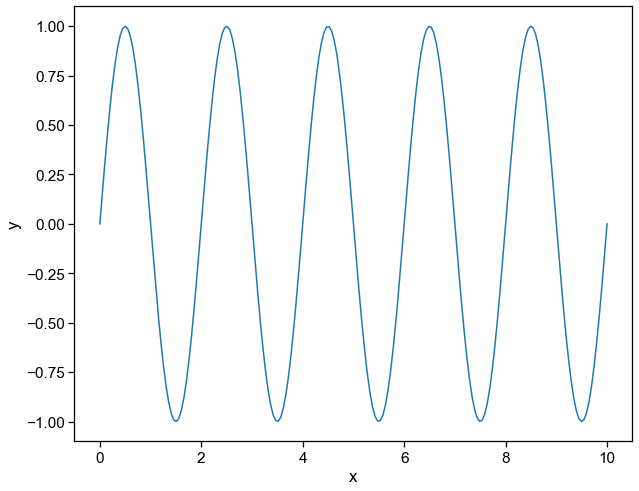

In [4]:
sns.lineplot(data=a, x='x', y='y')

<AxesSubplot:xlabel='xf', ylabel='yf'>

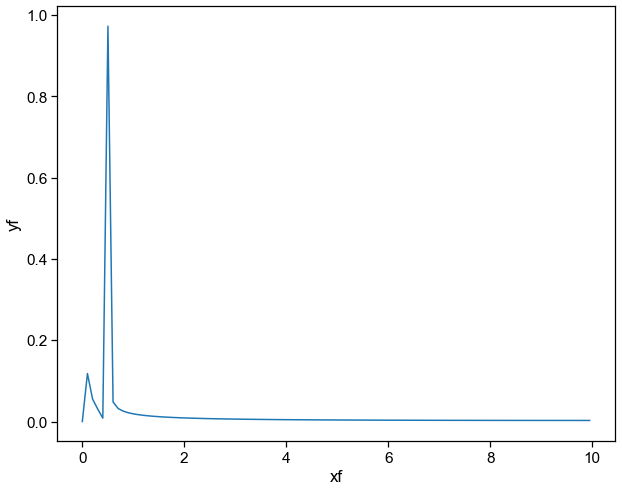

In [5]:
b = compute_fft_test(data=a, y='y', particle_u=1.0, fps=1.0)
sns.lineplot(data=b, x='xf', y='yf')

It works! Now using particle data.

In [6]:
def compute_fft(data, y, particle_u, fps):
    """Compute the finite fourier transform of the chosen particle.  

    Compute the fft using scipy. Use the detrended eccentricity column to determine the frequency at which the
    eccentricity of the wheel changes. I used this video for a background on the discrete fourier transform.
    https://www.youtube.com/watch?v=mkGsMWi_j4Q

    Args:
        x: real space, normally the time column of the particle.
        y: quantity to take the FFT of
        particle: particle to analyze. should be something like '0T11'
        fps (int): fps of video

    Returns:
        Dataframe column containing the fft of y
    """
    data = data[data['particle_u'] == particle_u]

    num_frames = int(len(data))  # the number of frames, or sample points

    # sample spacing
    spf = data['time'].values[1] - data['time'].values[0] # 1.0 / fps  # Frame every 1/fps seconds, seconds per frame

    y = data[y]
    detrend_y = signal.detrend(y)  # Detrend
    fft_particle = fftpack.fft(detrend_y)  # Compute fft.

    t_fi = pd.DataFrame()  # Initialize empty dataframe to store xf and yf columns

    # Actually calculating the FFT (formulas from examples and youtube video)
    t_fi['yf'] = 2.0 / num_frames * np.abs(fft_particle[:num_frames // 2])
    # 'np.abs' computes the magnitude of the complex number. fft_particle[:N//2] selects the first N/2 points.
    # Its multiplied by 2 to account for the mirrored half of the spectrum, then normalized by N.

    t_fi['xf'] = np.linspace(start=0.0, stop=1.0 / (2.0 * spf),
                                num=num_frames // 2)  # The double divison sign is integer division.
    t_fi['particle'] = np.full(len(t_fi), particle_u)

    return t_fi

<AxesSubplot:xlabel='time', ylabel='Angle'>

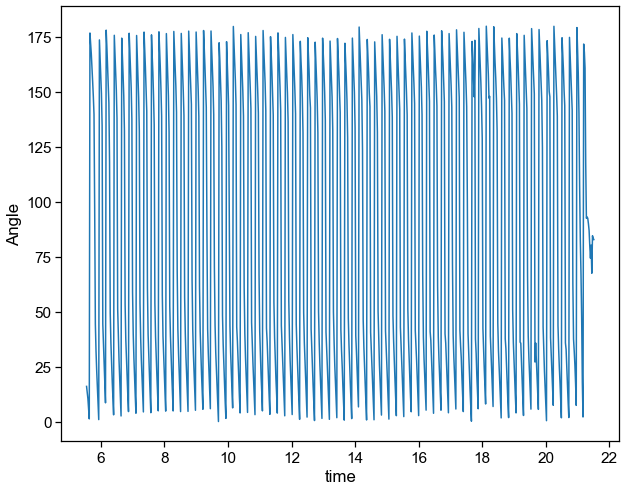

In [7]:
sns.lineplot(data=df[df['particle_u'] == '00T-306'], x='time', y='Angle')

(355.0, 380.0)

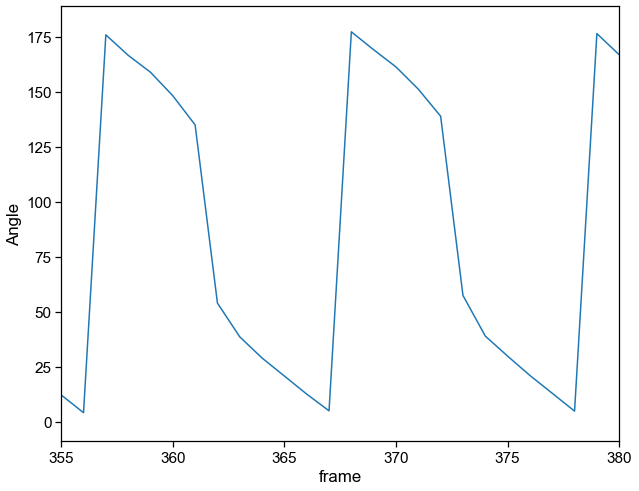

In [8]:
sns.lineplot(data=df[df.particle_u == "00T-306"], x='frame', y='Angle')
ax=plt.gca()
ax.set_xlim(355, 380)

[Text(0.5, 0, 'Frequency (1/s)'), Text(0, 0.5, 'Amplitude')]

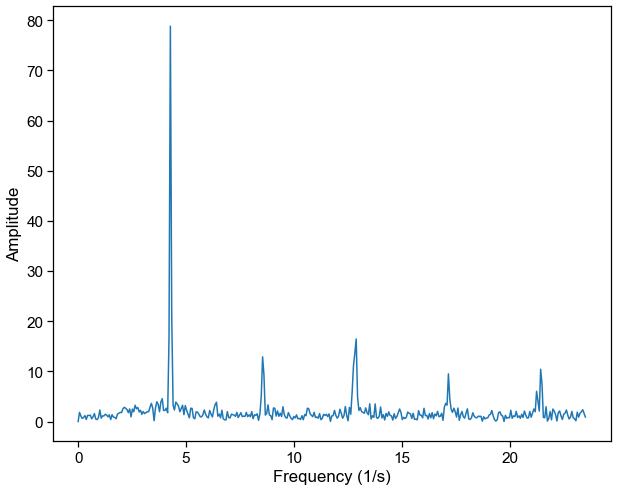

In [9]:
a = compute_fft(data=df, y='Angle', particle_u='00T-306', fps=47.0)
sns.lineplot(data=a, x='xf', y='yf')
ax = plt.gca()
ax.set(xlabel='Frequency (1/s)', ylabel='Amplitude')

In [10]:
a.loc[a['yf'].idxmax(), 'xf']

4.272727272727333

In [11]:
4.272 / 2 * 3.14

6.707040000000001

In [12]:
4.27 * 2

8.54